<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2023/blob/main/Module%206/17_Bayesian_Coin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook for the University of Tennessee, Knoxville, Department of Materials Science and Engineering Fall 2023 course, "Introduction in Machine Learning for Materials Science".
- Instructor Sergei V. Kalinin

- These examples are based on the book "Bayesian Analysis with Python" by Oswaldo Martin, https://www.packtpub.com/product/bayesian-analysis-with-python-second-edition/9781789341652

- Warning: the book uses the deprecated PyMC3 library. Current version is PyMC - see https://www.pymc.io/welcome.html
- The adaptation of the code to PYMC is available at the author's GitHub https://github.com/aloctavodia/BAP/tree/master/code_5

In [1]:
import numpy as np
from scipy.stats import norm, binom, beta, bernoulli, t, multivariate_normal, poisson, randint, entropy, laplace, logistic
import matplotlib.pyplot as plt

# Visualizing Gaussian Distirbution

Let's create Gaussian distribution with defined mean and dispersion, and draw three samples from it.

In [2]:
μ = 0.
σ = 1.
X = norm(μ, σ)
x = X.rvs(3)

print(x)

[ 0.81093451 -0.05165061 -0.30004396]


Now, let's visualize how Gaussian distributions look like for different mean and dispersions.  

[]

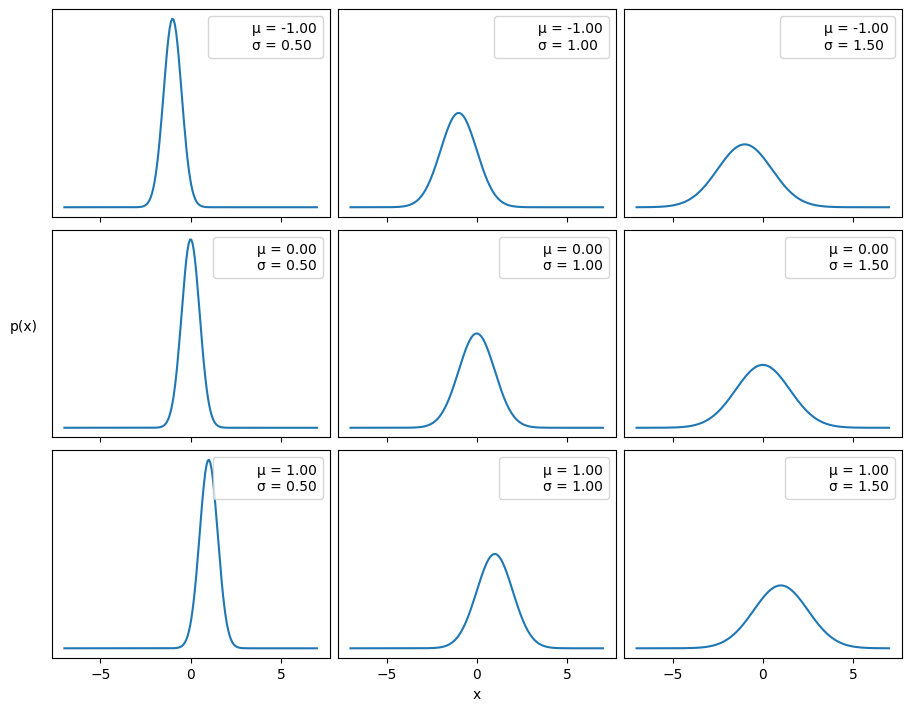

In [3]:
mu_params = [-1, 0, 1]
sd_params = [0.5, 1, 1.5]
x = np.linspace(-7, 7, 200)

_, ax = plt.subplots(len(mu_params), len(sd_params), sharex=True,
                     sharey=True,
                     figsize=(9, 7), constrained_layout=True)
for i in range(3):
    for j in range(3):
        mu = mu_params[i]
        sd = sd_params[j]
        y = norm(mu, sd).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot([], label="μ = {:3.2f}\nσ = {:3.2f}".format(mu,
                     sd), alpha=0)
        ax[i,j].legend(loc=1)

ax[2,1].set_xlabel('x')
ax[1,0].set_ylabel('p(x)', rotation=0, labelpad=20)
ax[1,0].set_yticks([])

# Coin toss the Bayesian way

## Visualizing Binomial Distirbution

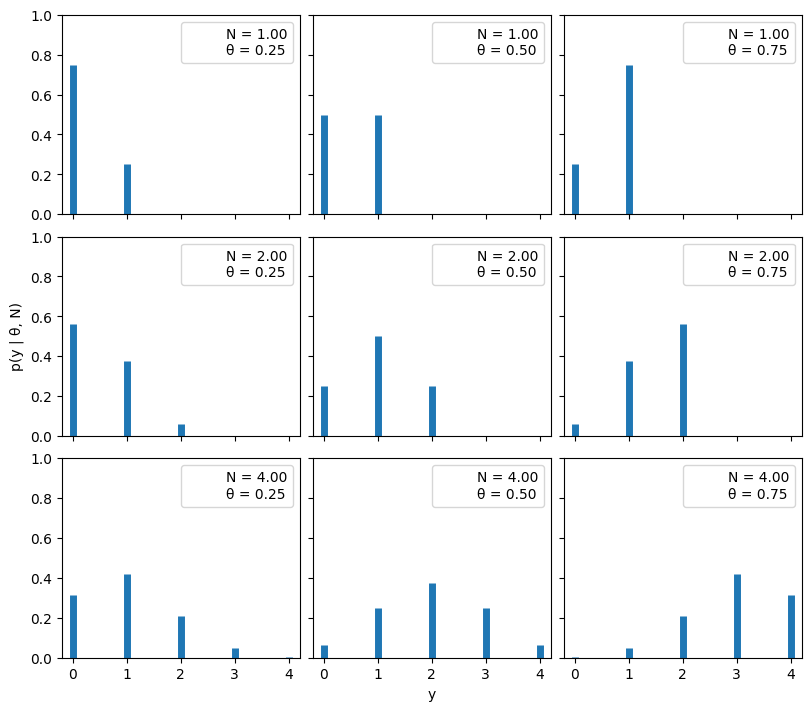

In [4]:
n_params = [1, 2, 4]  # Number of trials
p_params = [0.25, 0.5, 0.75]  # Probability of success

x = np.arange(0, max(n_params)+1)
f,ax = plt.subplots(len(n_params), len(p_params), sharex=True,
                    sharey=True,
                    figsize=(8, 7), constrained_layout=True)

for i in range(len(n_params)):
    for j in range(len(p_params)):
        n = n_params[i]
        p = p_params[j]

        y = binom(n=n, p=p).pmf(x)

        ax[i,j].vlines(x, 0, y, colors='C0', lw=5)
        ax[i,j].set_ylim(0, 1)
        ax[i,j].plot(0, 0, label="N = {:3.2f}\nθ = {:3.2f}".format(n,p), alpha=0)
        ax[i,j].legend()

        ax[2,1].set_xlabel('y')
        ax[1,0].set_ylabel('p(y | θ, N)')
        ax[0,0].set_xticks(x)

## Beta distribution

Text(0.07, 0.5, 'p(θ)')

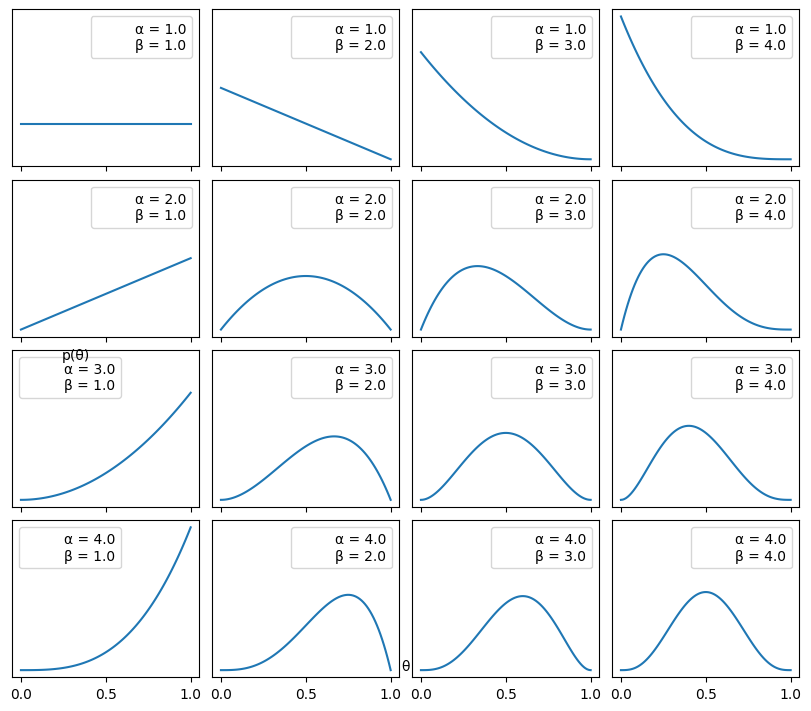

In [5]:
params = [1, 2, 3, 4]
x = np.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True,
                     sharey=True,
                     figsize=(8, 7), constrained_layout=True)

for i in range(4):
    for j in range(4):
        a = params[i]
        b = params[j]
        y = beta(a, b).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0, label="α = {:2.1f}\nβ = {:2.1f}".format(a,
                     b), alpha=0)
        ax[i,j].legend()
ax[1,0].set_yticks([])
ax[1,0].set_xticks([0, 0.5, 1])
f.text(0.5, 0.05, 'θ', ha='center')
f.text(0.07, 0.5, 'p(θ)', va='center', rotation=0)

## Coin toss

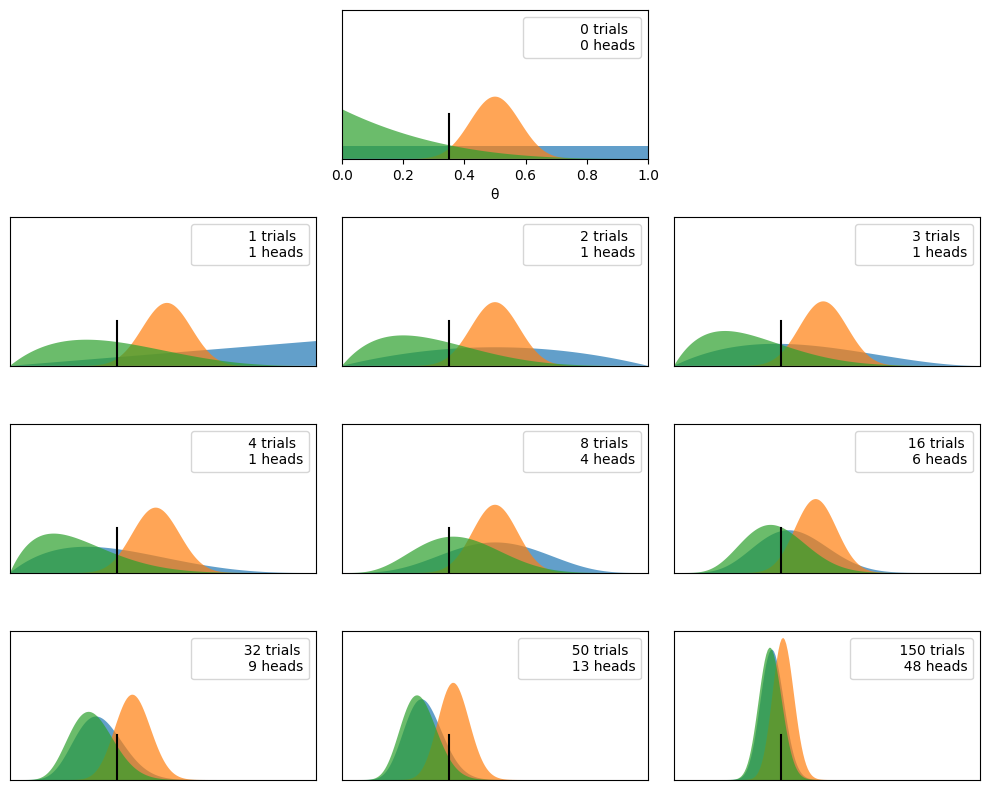

In [6]:
plt.figure(figsize=(10, 8))

n_trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
theta_real = 0.35

beta_params = [(1, 1), (20, 20), (1, 4)]
dist = beta
x = np.linspace(0, 1, 200)

for idx, N in enumerate(n_trials):
    if idx == 0:
        plt.subplot(4, 3, 2)
        plt.xlabel('θ')
    else:
        plt.subplot(4, 3, idx+3)
        plt.xticks([])
    y = data[idx]
    for (a_prior, b_prior) in beta_params:
        p_theta_given_y = dist.pdf(x, a_prior + y, b_prior + N - y)
        plt.fill_between(x, 0, p_theta_given_y, alpha=0.7)

    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label=f'{N:4d} trials\n{y:4d} heads', alpha=0)
    plt.xlim(0, 1)
    plt.ylim(0, 12)
    plt.legend()
    plt.yticks([])
plt.tight_layout()

# Bayesian Inference in action

Now, let's play with the concepts of priors, likelihoods, data, and posteriors. Let's start with the example where:
-  we generate data from Gaussian distribution N(mu, sigma).
- As a model, we assume that the data is sampled from Gaussian distribution with **unknown** parameters
- As a priors, we assume the uniform distribution for mu within a certain range, and uniform distribution for sigma

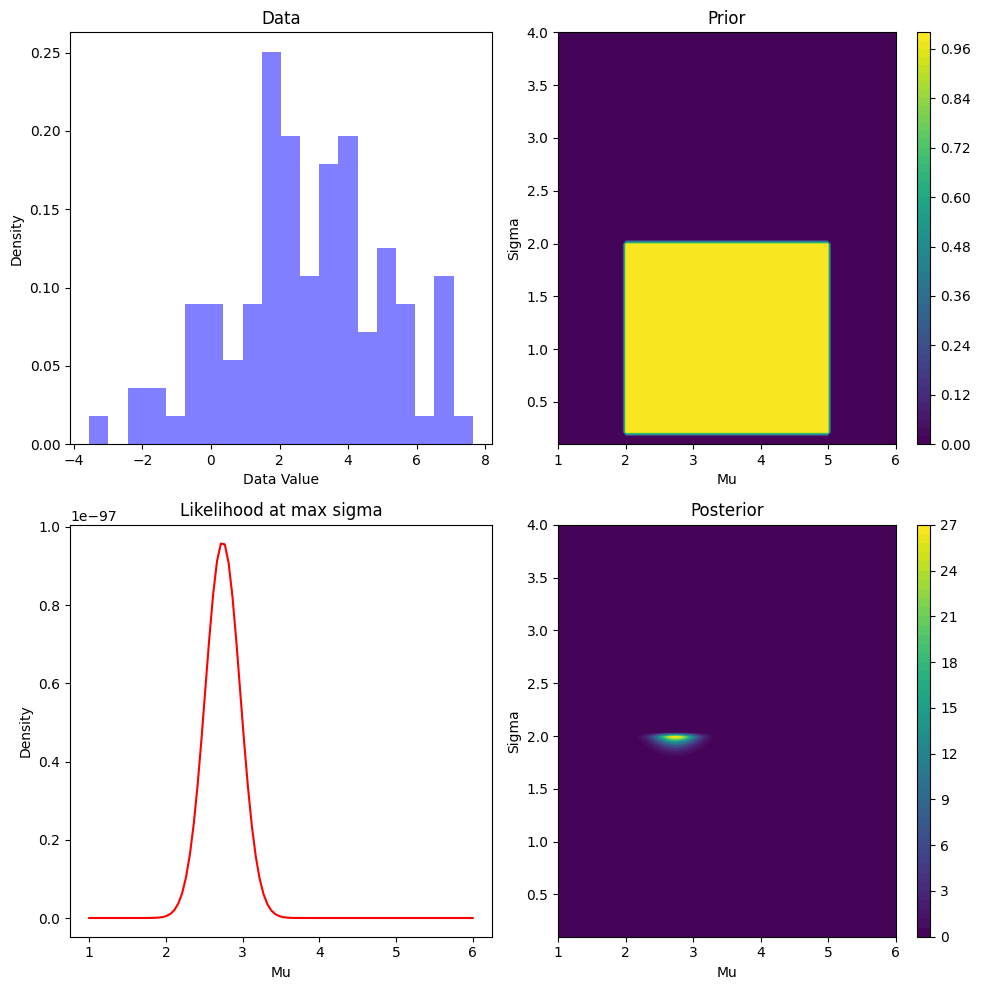

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some data
np.random.seed(42)
data = np.random.normal(3, 2.5, 100)

# Create a grid of mu and sigma values
mu_vals = np.linspace(1, 6, 100)
sigma_vals = np.linspace(0.1, 4, 100)

mu_grid, sigma_grid = np.meshgrid(mu_vals, sigma_vals)

# Prior for mu is uniform between 2 and 3
prior_mu = np.where((mu_grid > 2) & (mu_grid < 5), 1, 0)
# Prior for sigma is non-negative (for simplicity, uniform between 0.1 and 2)
prior_sigma = np.where((sigma_grid > 0.2) & (sigma_grid < 2), 1, 0) # 1  # This is a constant because we are assuming a uniform prior for sigma over its range
prior = prior_mu * prior_sigma

# Likelihood for both mu and sigma
likelihood = np.array([[np.prod(1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-(data - mu)**2 / (2 * sigma**2)))
                       for mu in mu_vals] for sigma in sigma_vals])

# Evidence
evidence = np.trapz(np.trapz(likelihood * prior, mu_vals, axis=1), sigma_vals)

# Posterior
posterior = likelihood * prior / evidence

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Data
axes[0, 0].hist(data, bins=20, density=True, alpha=0.5, color='blue', label='Data')
axes[0, 0].set_title('Data')
axes[0, 0].set_xlabel('Data Value')
axes[0, 0].set_ylabel('Density')

# Prior
contour = axes[0, 1].contourf(mu_grid, sigma_grid, prior, levels=50)
axes[0, 1].set_title('Prior')
axes[0, 1].set_xlabel('Mu')
axes[0, 1].set_ylabel('Sigma')
fig.colorbar(contour, ax=axes[0, 1], aspect=30)

# Likelihood (just showing maximum likelihood value for simplicity)
max_likelihood_idx = np.unravel_index(np.argmax(likelihood), likelihood.shape)
axes[1, 0].plot(mu_vals, likelihood[max_likelihood_idx[0]], 'r-')
axes[1, 0].set_title('Likelihood at max sigma')
axes[1, 0].set_xlabel('Mu')
axes[1, 0].set_ylabel('Density')

# Posterior
contour = axes[1, 1].contourf(mu_grid, sigma_grid, posterior, levels=50)
axes[1, 1].set_title('Posterior')
axes[1, 1].set_xlabel('Mu')
axes[1, 1].set_ylabel('Sigma')
fig.colorbar(contour, ax=axes[1, 1], aspect=30)

plt.tight_layout()
plt.show()


Now, experiment with this code. Consider what will happen if:
- you change the number of points from very small (say 3) to large (1000)
- what happens if parameters of our data generation process falls within the priors, or are well outside
- and experiment with narrow/broad priors
- consider the combinations of these (small data/large data, narrow/broad priors, correct/incorrect priors)

# More examples of BI

For examples below, identify what is data generation process, what is model/likelihood, what are priors, and what are posteriors.

## Example 1

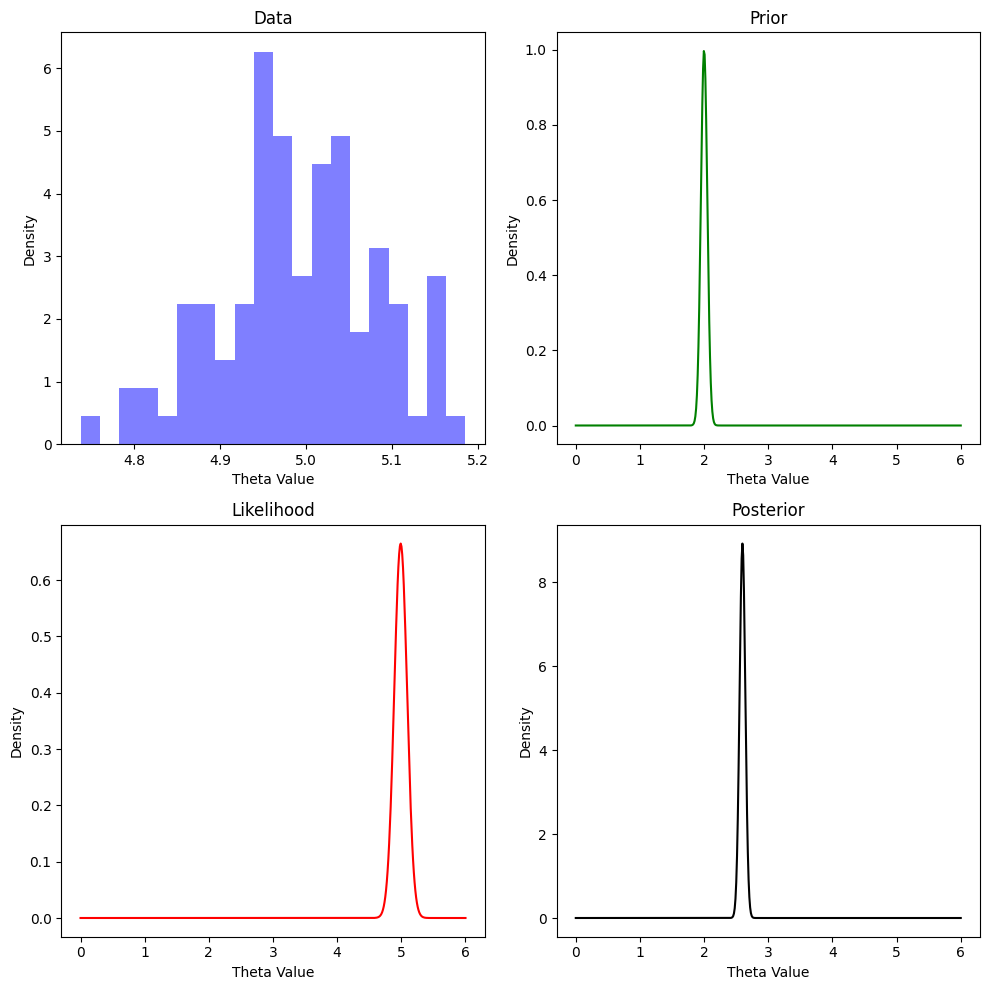

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some data
np.random.seed(42)
data = np.random.normal(5, 0.1, 100)

# Create a grid of theta values (our parameter of interest)
theta = np.linspace(0, 6, 500)

# Prior: N(2,1)
prior = np.exp(-(theta - 2)**2 / (2*(0.05)**2))

# Likelihood: Product of N(theta,1) for each data point
likelihood = np.prod([np.exp(-(data - t)**2 / (2*1**2)) for t in theta], axis=1)

# Evidence (computed by integrating the product of the likelihood and the prior over all theta)
evidence = np.trapz(likelihood * prior, theta)

# Posterior: likelihood * prior / evidence
posterior = likelihood * prior / evidence

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Data
axes[0, 0].hist(data, bins=20, density=True, alpha=0.5, color='blue', label='Data')
axes[0, 0].set_title('Data')
axes[0, 0].set_xlabel('Theta Value')
axes[0, 0].set_ylabel('Density')

# Prior
axes[0, 1].plot(theta, prior, 'g-')
axes[0, 1].set_title('Prior')
axes[0, 1].set_xlabel('Theta Value')
axes[0, 1].set_ylabel('Density')

# Likelihood
axes[1, 0].plot(theta, likelihood, 'r-')
axes[1, 0].set_title('Likelihood')
axes[1, 0].set_xlabel('Theta Value')
axes[1, 0].set_ylabel('Density')

# Posterior
axes[1, 1].plot(theta, posterior, 'k-')
axes[1, 1].set_title('Posterior')
axes[1, 1].set_xlabel('Theta Value')
axes[1, 1].set_ylabel('Density')

plt.tight_layout()
plt.show()


## Example 2

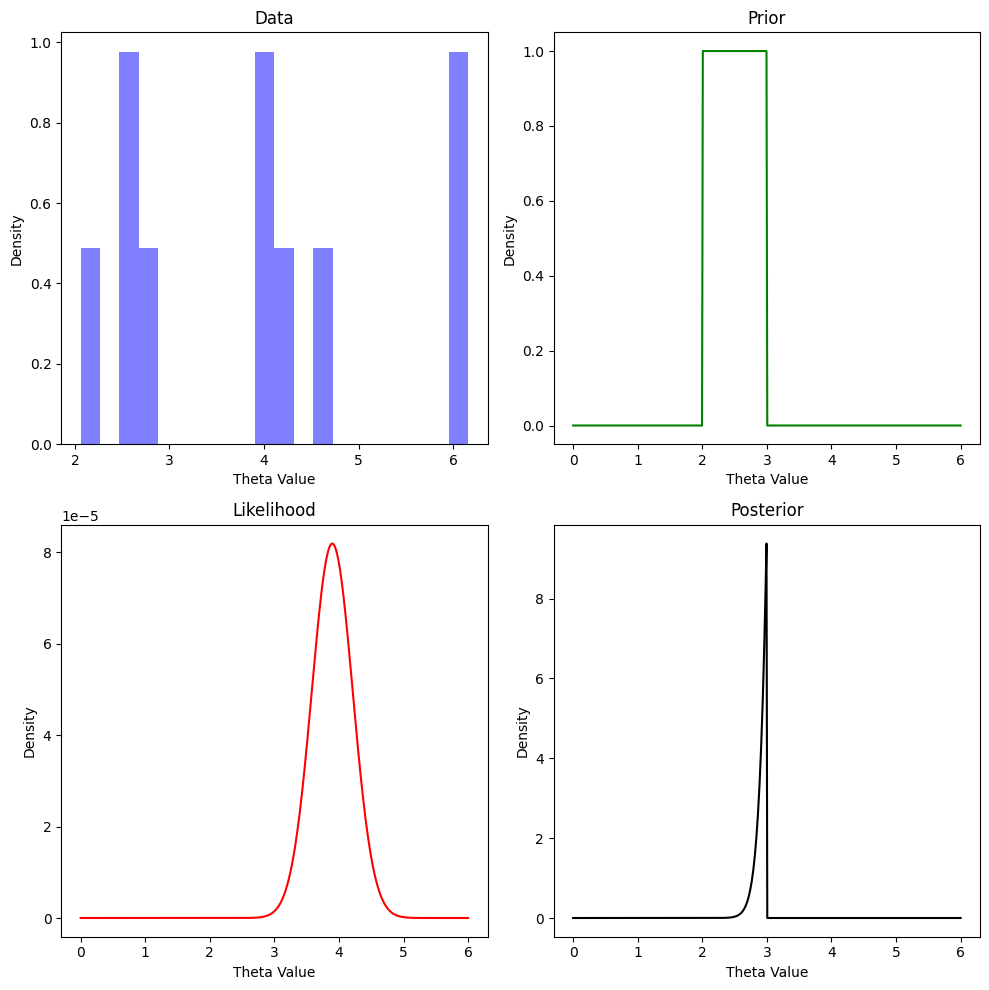

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some data
np.random.seed(42)
data = np.random.normal(3, 2, 10)

# Create a grid of theta values (our parameter of interest)
theta = np.linspace(0, 6, 500)

# Prior: Uniform in the range [2, 3]
prior = np.where((theta >= 2) & (theta <= 3), 1, 0)

# Likelihood: Product of N(theta,1) for each data point
likelihood = np.exp(-0.5 * np.sum((data[:, None] - theta)**2, axis=0))

# Evidence (computed by integrating the product of the likelihood and the prior over all theta)
evidence = np.trapz(likelihood * prior, theta)

# Posterior: likelihood * prior / evidence
posterior = likelihood * prior / evidence

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Data
axes[0, 0].hist(data, bins=20, density=True, alpha=0.5, color='blue')
axes[0, 0].set_title('Data')
axes[0, 0].set_xlabel('Theta Value')
axes[0, 0].set_ylabel('Density')

# Prior
axes[0, 1].plot(theta, prior, 'g-')
axes[0, 1].set_title('Prior')
axes[0, 1].set_xlabel('Theta Value')
axes[0, 1].set_ylabel('Density')

# Likelihood
axes[1, 0].plot(theta, likelihood, 'r-')
axes[1, 0].set_title('Likelihood')
axes[1, 0].set_xlabel('Theta Value')
axes[1, 0].set_ylabel('Density')

# Posterior
axes[1, 1].plot(theta, posterior, 'k-')
axes[1, 1].set_title('Posterior')
axes[1, 1].set_xlabel('Theta Value')
axes[1, 1].set_ylabel('Density')

plt.tight_layout()
plt.show()


## Example 3

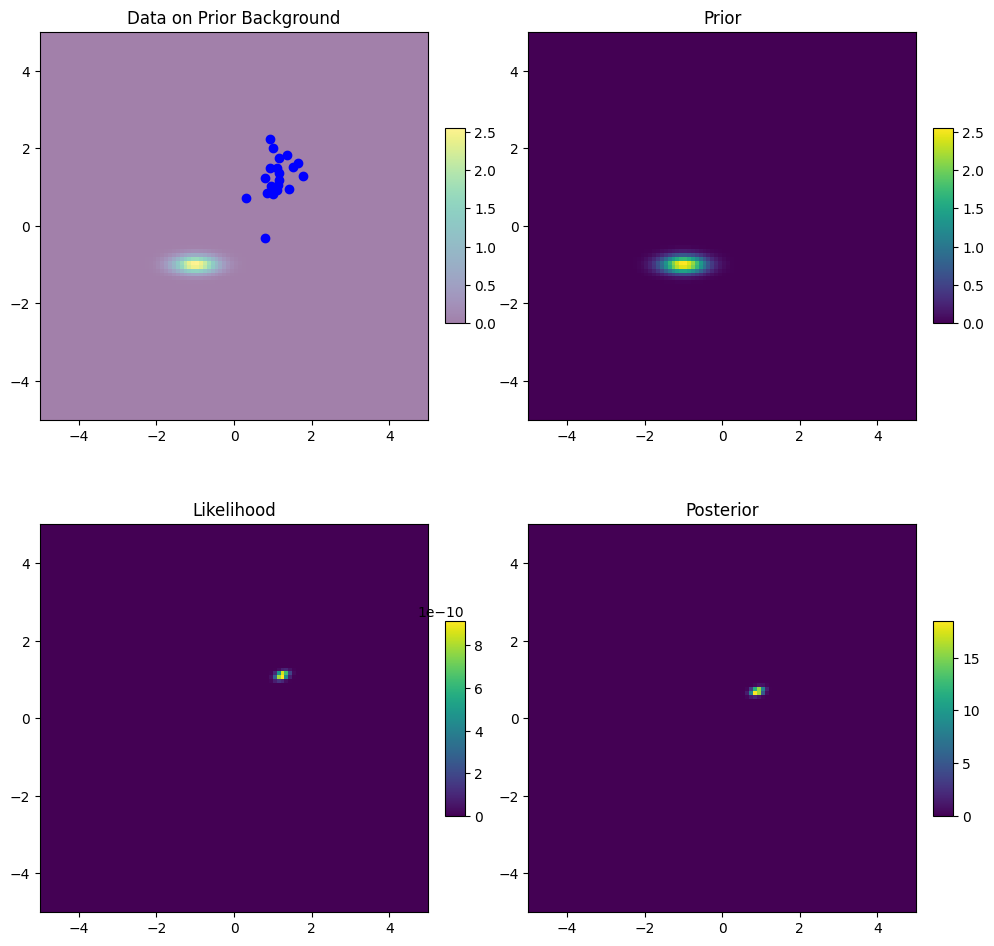

Evidence: 5.499226511959399e-51


In [10]:
import numpy as np
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt

# Generate synthetic data for illustration
np.random.seed(0)
mean_true = [1, 1]
cov_matrix = [[0.1, 0.05], [0.05, 0.25]]
D = np.random.multivariate_normal(mean_true, cov_matrix, size=20)

# Define the 2D likelihood function
def likelihood(mu_x, mu_y):
    return np.prod(multivariate_normal.pdf(D, mean=[mu_x, mu_y], cov=cov_matrix))

# Define the priors for mu_x and mu_y
def prior_x(mu_x):
    return norm.pdf(mu_x, -1, 0.15)

def prior_y(mu_y):
    return norm.pdf(mu_y, -1, 0.4)

# Set up a grid of values for mu_x and mu_y
grid_size = 100

mu_x_values = np.linspace(-5, 5, grid_size)
mu_y_values = np.linspace(-5, 5, grid_size)
likelihood_grid = np.zeros((grid_size, grid_size))
prior_grid = np.zeros((grid_size, grid_size))

# Compute the likelihood and prior at each grid point
for i, mu_x in enumerate(mu_x_values):
    for j, mu_y in enumerate(mu_y_values):
        likelihood_grid[i, j] = likelihood(mu_x, mu_y)
        prior_grid[i, j] = prior_x(mu_x) * prior_y(mu_y)

# Approximate the evidence by summing the product of the likelihood and prior at each grid point
# and then multiplying by the area represented by each grid point.
evidence = np.sum(likelihood_grid * prior_grid) * (mu_x_values[1] - mu_x_values[0]) * (mu_y_values[1] - mu_y_values[0])

# Compute the posterior
posterior_grid = (likelihood_grid * prior_grid) / evidence

# Plotting

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Data plot
cax_data = axes[0, 0].imshow(prior_grid, extent=(-5, 5, -5, 5), origin='lower', alpha=0.5)
cbar_data = plt.colorbar(cax_data, ax=axes[0, 0], aspect=10, fraction=0.046, pad=0.04)
cbar_data.ax.tick_params(labelsize=10)
axes[0, 0].scatter(D[:, 0], D[:, 1], color='blue')
axes[0, 0].set_xlim(-5, 5)
axes[0, 0].set_ylim(-5, 5)
axes[0, 0].set_title('Data on Prior Background')

# Prior plot
cax2 = axes[0, 1].imshow(prior_grid, extent=(-5, 5, -5, 5), origin='lower')
cbar2 = plt.colorbar(cax2, ax=axes[0, 1], aspect=10, fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=10)
axes[0, 1].set_title('Prior')

# Likelihood plot
cax1 = axes[1, 0].imshow(likelihood_grid, extent=(-5, 5, -5, 5), origin='lower')
cbar1 = plt.colorbar(cax1, ax=axes[1, 0], aspect=10, fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=10)
axes[1, 0].set_title('Likelihood')

# Posterior plot
cax4 = axes[1, 1].imshow(posterior_grid, extent=(-5, 5, -5, 5), origin='lower')
cbar4 = plt.colorbar(cax4, ax=axes[1, 1], aspect=10, fraction=0.046, pad=0.04)
cbar4.ax.tick_params(labelsize=10)
axes[1, 1].set_title('Posterior')

plt.tight_layout()
plt.show()

print("Evidence:", evidence)